# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import pickle
import torch.optim as optim


In [33]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/ComputerVision_Fall2019/Md_Arif_112669645_hw4/'

/content/gdrive/My Drive/ComputerVision_Fall2019/Md_Arif_112669645_hw4


In [35]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.3.0+cu100
True
10.0.130


In [59]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  # Write your code here
  # normalize img pixels to [-1, 1]
  norm_img= np.float32(cv2.normalize(img,None,0,1,cv2.NORM_MINMAX))
  norm_img-=0.5
  return norm_img*2

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    # Write your Data Augmentation code here
    # mirroring
    
    if augment:
      for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
                img = img[:, ::-1] ## Taking Mirror Image 
            else:
                img = cv2.imread(filename, 0)
                img = img[:, ::-1]

            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
    if rotate_90:
        img_rotate_clock = [np.rot90(img, axes=(-2,-1)) for img in data]
        data.extend(img_rotate_clock)
        labels.extend(labels)
        
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'TallBuilding', 1: 'InsideCity', 2: 'Mountain', 3: 'LivingRoom', 4: 'Industrial', 5: 'Store', 6: 'OpenCountry', 7: 'Suburb', 8: 'Street', 9: 'Kitchen', 10: 'Forest', 11: 'Coast', 12: 'Highway', 13: 'Office', 14: 'Flower', 15: 'Bedroom'} 


In [60]:
# load data into size (64, 64)

start_time = time.time()
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

print('\033[1m' + 'Time Taken to load the Training and Test Data Set: ' + '--- %s minutes ---' % round((time.time() - start_time)/60,2))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
4800
50
Finish loading 96 minibatches(=50) of training sampl

Flower


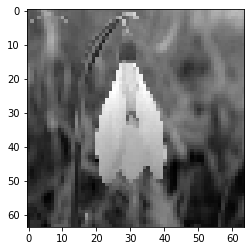

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

In [0]:
# # As loading the data from the source for the first time is time consuming, so you can pkl or save the data in a compact way such that subsequent data loading is faster
# # Save intermediate image data into disk
file = open('trainloader_small.pkl','wb')
pickle.dump(trainloader_small, file)

file = open('testloader_small.pkl','wb')
pickle.dump(testloader_small, file)
file.close()


In [65]:
# Load intermediate image data from disk
file = open('trainloader_small.pkl', 'rb')
trainloader_small = pickle.load(file)
file.close()

file = open('testloader_small.pkl', 'rb')
testloader_small = pickle.load(file)
file.close()

print('\033[1m' + 'Training Samples: ' + str(len(trainloader_small)*50)) # Verify number of training samples
print('\033[1m' + 'Test Samples: ' +  str(len(testloader_small)*50))   # Verify number of testing samples


Training Samples: 4800
Test Samples: 400


In [38]:
print('\033[1m' + 'Total Training Batches: ' + str(len(trainloader_small))) 
print('\033[1m' + 'Total Test Batches: ' + str(len(testloader_small))) 

Total Training Batches: 96
Total Test Batches: 8


2
<class 'tuple'>
torch.Size([1, 64, 64])
torch.Size([])
label tensor(0)


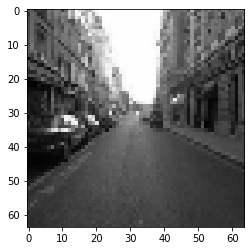

In [0]:
## Basic Data Sanity Checks
sample = next(iter(trainloader_small))
print(len(sample))
print(type(sample))
smpl_img, smpl_lbl= sample

i=10
print(smpl_img[i].shape)
print(smpl_lbl[i].shape)

plt.imshow(smpl_img[0].squeeze(),cmap= 'gray')
print('label',smpl_lbl[i] )

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [50]:
# ==========================================
#       Define Network Architecture
# ==========================================

class CNN_Ver1(nn.Module):
    def __init__(self, input_channels=1, num_classes=16):
      super(CNN_Ver1, self).__init__()
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, padding=2,stride=1))
      self.layer1.add_module("Relu1", nn.ReLU())
      self.layer1.add_module("MaxPool1", nn.MaxPool2d(kernel_size=2))
      
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1))
      self.layer2.add_module("Relu2", nn.ReLU())
      self.layer2.add_module("MaxPool2", nn.MaxPool2d(kernel_size=2))     
      
      self.fully_connected = nn.Linear(32 * 16 * 16, num_classes)
 
    def forward(self, x):
    	x = self.layer1(x)
    	x = self.layer2(x)
    	x = x.view(x.size(0),-1)
    	x = self.fully_connected(x)
    	return x

# defining the model
model_ver1 = CNN_Ver1()

# defining the optimizer
optimizer = optim.Adam(model_ver1.parameters(), lr=0.001)

# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model_ver1 = model_ver1.cuda()
    criterion = criterion.cuda()
    
print(model_ver1)

CNN_Ver1(
  (layer1): Sequential(
    (Conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Relu1): ReLU()
    (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (Conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (Relu2): ReLU()
    (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Linear(in_features=8192, out_features=16, bias=True)
)


In [0]:
# ==========================================
#         Optimize/Train Network
# ==========================================
## Defining Training Framework

def train_model(train_set, epoch,model_version,print_mini_batch_loss= False, print_epoch_loss= False):
    model_version.train()
    if print_epoch_loss:
        print('\033[1m' + 'Performance Statistics for Epoch Number :' + str(epoch + 1))
    train_running_loss = 0.0
    train_total_loss= 0.0
    for batch_num, data in enumerate(train_set, 0):
        # getting the inputs; data is a tensor tuple list of [inputs, labels]
        x_train, y_train = data   
        x_train = x_train.float() 

        # converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()

        # zero the parameter gradients
        # prediction for training set
        # computing the training loss
        # computing the updated weights of all the model parameters

        optimizer.zero_grad()
        output_train = model_version(x_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss_train.item()
        train_total_loss += loss_train.item()

        if batch_num % 20 == 19:    # print every 20 mini-batches
            if print_mini_batch_loss:
                print('\033[1m' + '[Batch NO.: %d, Mini Batch: %5d] loss: %.3f' %
                      (epoch + 1, batch_num + 1, train_running_loss / 20))
            train_running_loss = 0.0
    train_losses.append(train_total_loss/(batch_num + 1))
    if print_epoch_loss:
        print('\033[1m' + '[Avg Loss for the Epoch NO.: %d, Loss: %.3f]' % (epoch + 1, train_total_loss/(batch_num + 1)))
        print('\n')


In [0]:
start_time = time.time()
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# loop over the dataset multiple times
for epoch in range(n_epochs):
   train_model(trainloader_small,epoch,model_ver1, False, True)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))


Performance Statistics for Epoch Number :1
[Avg Loss for the Epoch NO.: 1, Loss: 2.361]


Performance Statistics for Epoch Number :2
[Avg Loss for the Epoch NO.: 2, Loss: 1.632]


Performance Statistics for Epoch Number :3
[Avg Loss for the Epoch NO.: 3, Loss: 1.301]


Performance Statistics for Epoch Number :4
[Avg Loss for the Epoch NO.: 4, Loss: 1.092]


Performance Statistics for Epoch Number :5
[Avg Loss for the Epoch NO.: 5, Loss: 0.935]


Performance Statistics for Epoch Number :6
[Avg Loss for the Epoch NO.: 6, Loss: 0.802]


Performance Statistics for Epoch Number :7
[Avg Loss for the Epoch NO.: 7, Loss: 0.665]


Performance Statistics for Epoch Number :8
[Avg Loss for the Epoch NO.: 8, Loss: 0.544]


Performance Statistics for Epoch Number :9
[Avg Loss for the Epoch NO.: 9, Loss: 0.443]


Performance Statistics for Epoch Number :10
[Avg Loss for the Epoch NO.: 10, Loss: 0.410]


Performance Statistics for Epoch Number :11
[Avg Loss for the Epoch NO.: 11, Loss: 0.388]


Perfor

In [0]:
file = open('model_ver1.pkl','wb')
pickle.dump(model_ver1, file)
file.close()

file = open('model_ver1.pkl', 'rb')
model_ver1 = pickle.load(file)
file.close()


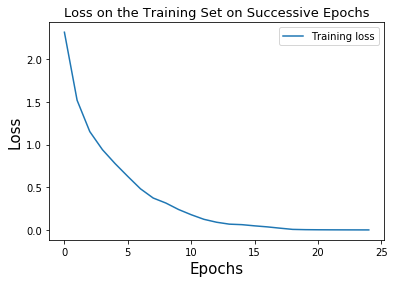

In [0]:
# plotting the training loss
plt.plot(train_losses, label='Training loss')
plt.title('Loss on the Training Set on Successive Epochs',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)
plt.show()


In [62]:
# ==========================================
#            Evaluating Network
# ==========================================

def test_model(test_data,model_version):
    start_time = time.time()
    # prediction and Accuracy for Test set
    correct = 0
    total = 0
    model_version.eval()            
    for batch_num, data in enumerate(test_data, 0):
        x_test, y_test = data
        x_test = x_test.float()

        if torch.cuda.is_available():
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        y_pred = model_version(x_test.cuda())
        _, predicted = torch.max(y_pred.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    print('\033[1m' + 'Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    print('\033[1m' + 'Time Taken for Evaluating Model on Test: ' + '--- %s seconds ---' % round((time.time() - start_time),2))

test_model(testloader_small,model_ver1)


Accuracy of the network on the test images: 62 %
Time Taken for Evaluating Model on Test: --- 0.05 seconds ---


### **Part 2 : Let's Try to Increase Accuracy  by Following Techniques**

### **Method1: Adding Batch Normalization:**

In [0]:
class CNN_Ver2(nn.Module):
    def __init__(self, input_channels=1, num_classes=16):
      super(CNN_Ver2, self).__init__()
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, padding=2,stride=1))
      self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=16))
      self.layer1.add_module("Relu1", nn.ReLU())
      self.layer1.add_module("MaxPool1", nn.MaxPool2d(kernel_size=2))
      
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1))
      self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
      self.layer2.add_module("Relu2", nn.ReLU())
      self.layer2.add_module("MaxPool2", nn.MaxPool2d(kernel_size=2))     
      
      self.fully_connected = nn.Linear(32 * 16 * 16, num_classes)
 
    def forward(self, x):
    	x = self.layer1(x)
    	x = self.layer2(x)
    	x = x.view(x.size(0),-1)
    	x = self.fully_connected(x)
    	return x

# defining the model
model_ver2 = CNN_Ver2()
optimizer = optim.Adam(model_ver2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model_ver2 = model_ver2.cuda()
    criterion = criterion.cuda()
    
print(model_ver2)

CNN_Ver2(
  (layer1): Sequential(
    (Conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (BN1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu1): ReLU()
    (MaxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (Conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (BN2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu2): ReLU()
    (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected): Linear(in_features=8192, out_features=16, bias=True)
)


### Training the Method1 Model

In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 25
for epoch in range(n_epochs):
   train_model(trainloader_small,epoch,model_ver2,False, False)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))


Finished Training
Time Taken to Train the Model: --- 0.54 mins ---


### Evaluating the Method1 Model on Test Data

In [0]:
test_model(testloader_small,model_ver2)

Accuracy of the network on the test images: 64 %
Time Taken for Evaluating Model on Test: --- 0.06 seconds ---


### **We observe that Adding Batch Normalization Increases our Accuracy Marginally by 2-5%**

### **Method2: Adding Dropout Layer:**

In [0]:
class CNN_Ver3(nn.Module):
    def __init__(self, input_channels=1, num_classes=16):
      super(CNN_Ver3, self).__init__()
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, padding=2,stride=1))
      self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=16))
      self.layer1.add_module("Relu1", nn.ReLU())
      self.layer1.add_module("MaxPool1", nn.MaxPool2d(kernel_size=2))
      
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1))
      self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
      self.layer2.add_module("Relu2", nn.ReLU())
      self.layer2.add_module("MaxPool2", nn.MaxPool2d(kernel_size=2))
      self.layer2.add_module("dropout", nn.Dropout2d(0.001))     
      
      self.fully_connected = nn.Linear(32 * 16 * 16, num_classes)
 
    def forward(self, x):
    	x = self.layer1(x)
    	x = self.layer2(x)
    	x = x.view(x.size(0),-1)
    	x = self.fully_connected(x)
    	return x

# defining the model
model_ver3 = CNN_Ver3()
optimizer = optim.Adam(model_ver3.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model_ver3 = model_ver3.cuda()
    criterion = criterion.cuda()


In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 25
for epoch in range(n_epochs):
   train_model(trainloader_small,epoch,model_ver3,False, False)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))

test_model(testloader_small,model_ver3)

Finished Training
Time Taken to Train the Model: --- 0.55 mins ---
Accuracy of the network on the test images: 62 %
Time Taken for Evaluating Model on Test: --- 0.04 seconds ---


### **We observe that Adding Dropout Layer doesn't Increase our Accuracy much, by ~1-2%**

### **Method3: Changing The Activation Function to Sigmoid and Leaky Relu:**

In [0]:
class CNN_Ver4(nn.Module):
    def __init__(self, input_channels=1, num_classes=16):
      super(CNN_Ver4, self).__init__()
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, padding=2,stride=1))
      self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=16))
      self.layer1.add_module("Sigmoid1", nn.Sigmoid())
      self.layer1.add_module("MaxPool1", nn.MaxPool2d(kernel_size=2))
      
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1))
      self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
      self.layer2.add_module("Sigmoid2", nn.Sigmoid())
      self.layer2.add_module("MaxPool2", nn.MaxPool2d(kernel_size=2))     
      
      self.fully_connected = nn.Linear(32 * 16 * 16, num_classes)
 
    def forward(self, x):
    	x = self.layer1(x)
    	x = self.layer2(x)
    	x = x.view(x.size(0),-1)
    	x = self.fully_connected(x)
    	return x

# defining the model
model_ver4 = CNN_Ver4()
optimizer = optim.Adam(model_ver4.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model_ver4 = model_ver4.cuda()
    criterion = criterion.cuda()
    

In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 25
for epoch in range(n_epochs):
   train_model(trainloader_small,epoch,model_ver4,False, False)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))

test_model(testloader_small,model_ver4)

Finished Training
Time Taken to Train the Model: --- 0.55 mins ---
Accuracy of the network on the test images: 58 %
Time Taken for Evaluating Model on Test: --- 0.04 seconds ---


### We observe that Changing Activation Function to *Sigmoid* deteriorates our Accuracy by ~5-10%

### Let's check with Leaky Relu

In [0]:
class CNN_Ver5(nn.Module):
    def __init__(self, input_channels=1, num_classes=16):
      super(CNN_Ver5, self).__init__()
      self.layer1 = nn.Sequential()
      self.layer1.add_module("Conv1", nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, padding=2,stride=1))
      self.layer1.add_module("BN1", nn.BatchNorm2d(num_features=16))
      self.layer1.add_module("Lrelu1", nn.LeakyReLU())
      self.layer1.add_module("MaxPool1", nn.MaxPool2d(kernel_size=2))
      
      self.layer2 = nn.Sequential()
      self.layer2.add_module("Conv2", nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2, stride=1))
      self.layer2.add_module("BN2", nn.BatchNorm2d(num_features=32))
      self.layer2.add_module("Lrelu2", nn.LeakyReLU())
      self.layer2.add_module("MaxPool2", nn.MaxPool2d(kernel_size=2))     
      
      self.fully_connected = nn.Linear(32 * 16 * 16, num_classes)
 
    def forward(self, x):
    	x = self.layer1(x)
    	x = self.layer2(x)
    	x = x.view(x.size(0),-1)
    	x = self.fully_connected(x)
    	return x

# defining the model
model_ver5 = CNN_Ver5()
optimizer = optim.Adam(model_ver5.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model_ver5 = model_ver5.cuda()
    criterion = criterion.cuda()
    

In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 25
for epoch in range(n_epochs):
   train_model(trainloader_small,epoch,model_ver5,False, False)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))

test_model(testloader_small,model_ver5)

Finished Training
Time Taken to Train the Model: --- 0.55 mins ---
Accuracy of the network on the test images: 64 %
Time Taken for Evaluating Model on Test: --- 0.04 seconds ---


### We observe that Changing Activation Function to *LeakyRelu* gives more or less same Accuracy as Relu

### **Method4: Augmenting Data by rotating the Image and checking Accuracy on Trained Model1:**

In [44]:
# load data into size (64, 64)

start_time = time.time()
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small_rot = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True,rotate_90=True))
train_num = len(trainloader_small_rot)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

print('\033[1m' + 'Time Taken to load the Training: ' + '--- %s minutes ---' % round((time.time() - start_time)/60,2))


Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
9600
50
Finish loading 192 minibatches(=50) of training samp

In [53]:
# # # Save intermediate image data into disk
# file = open('trainloader_small_rot.pkl','wb')
# pickle.dump(trainloader_small_rot, file)


# Load intermediate image data from disk
file = open('trainloader_small_rot.pkl', 'rb')
trainloader_small_rot = pickle.load(file)
file.close()
# Verify number of training samples after rotating images and augmenting
print('\033[1m' + 'Training Samples: ' + str(len(trainloader_small_rot)*50)) 



Training Samples: 9600


In [54]:
## Training using the CNN_Ver1, model_ver1

start_time = time.time()
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# loop over the dataset multiple times
for epoch in range(n_epochs):
   train_model(trainloader_small_rot,epoch,model_ver1, False, True)

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))


Performance Statistics for Epoch Number :1
[Avg Loss for the Epoch NO.: 1, Loss: 2.274]


Performance Statistics for Epoch Number :2
[Avg Loss for the Epoch NO.: 2, Loss: 1.707]


Performance Statistics for Epoch Number :3
[Avg Loss for the Epoch NO.: 3, Loss: 1.365]


Performance Statistics for Epoch Number :4
[Avg Loss for the Epoch NO.: 4, Loss: 1.134]


Performance Statistics for Epoch Number :5
[Avg Loss for the Epoch NO.: 5, Loss: 0.954]


Performance Statistics for Epoch Number :6
[Avg Loss for the Epoch NO.: 6, Loss: 0.787]


Performance Statistics for Epoch Number :7
[Avg Loss for the Epoch NO.: 7, Loss: 0.630]


Performance Statistics for Epoch Number :8
[Avg Loss for the Epoch NO.: 8, Loss: 0.534]


Performance Statistics for Epoch Number :9
[Avg Loss for the Epoch NO.: 9, Loss: 0.475]


Performance Statistics for Epoch Number :10
[Avg Loss for the Epoch NO.: 10, Loss: 0.447]


Performance Statistics for Epoch Number :11
[Avg Loss for the Epoch NO.: 11, Loss: 0.349]


Perfor

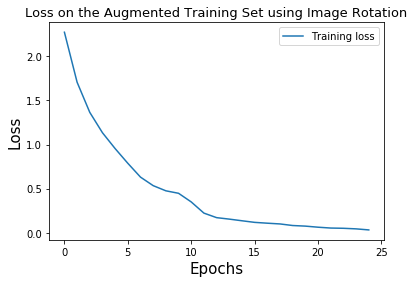

In [55]:
# plotting the training loss
plt.plot(train_losses, label='Training loss')
plt.title('Loss on the Augmented Training Set using Image Rotation',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)
plt.show()


In [58]:
file = open('testloader_small.pkl', 'rb')
testloader_small = pickle.load(file)
file.close()
test_model(testloader_small,model_ver1)


Accuracy of the network on the test images: 36 %
Time Taken for Evaluating Model on Test: --- 0.05 seconds ---


**We observe that with Rotating Image and Augmentating in the Training Set, our accuracy falls by a significant amount, so this has least significance**

### ***Complete Report for the Question 1:***

**Part1 :**
*   On the given 2400 training and 400 test images, we augmented Data by doing mirror image 
*   We Normalized the training and test data, and centered around zero
*   Build first CNN model with below parameters:
>  Two Hidden Layers, [Kernel Size = 5 with Stride= 1 and padding =2],
> Activation Function : Relu,
> MaxPool : [kernel_size=2, stride=2, padding=0]
*   Time taken for training the data set 0.48mins and time taken for evaluating the model on test data 0.05secs
*   **Accuracy Observed = 62%**

**Part2 :**
We Apply below Methods to further investigate and improve our Accuracy:
# Method1: Batch Normalization
>  Layer1: nn.BatchNorm2d(num_features=16) , Layer2: nn.BatchNorm2d(num_features=32)
>> **Accuracy Observed = 64%**

# Method2: Adding Dropout Layer
>  Layer2: nn.Dropout2d(0.001) 
>> **Accuracy Observed = 62%**

# Method3: Changing Activation Function to Sigmoid , Leaky Relu
>  Adding Sigmoid and Leaky Relu in Layer1 and Layer2: 
>> **Accuracy Observed = 58%** with nn.Sigmoid()

>> **Accuracy Observed = 58%** with nn.LeakyReLU()

# Method4: Image Rotation
>  Rotaing Images by 90degree and augmenting in the dataset, our 4800 Training Set doubles to 9600 Training Samples
>> **Accuracy Observed = 36%, worst performance observed**










## **Summary : Best Accuracy observed = 64% by using RELU Activation Function and Batch Normalisation**

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))


In [0]:
# file = open('trainloader_large.pkl','wb')
# pickle.dump(trainloader_large, file)
# file.close()

# file = open('testloader_large.pkl','wb')
# pickle.dump(testloader_large, file)
# file.close()

In [0]:
# Load intermediate image data from disk
file = open('trainloader_large.pkl', 'rb')
trainloader_large = pickle.load(file)
file.close()

file = open('testloader_large.pkl', 'rb')
testloader_large = pickle.load(file)
file.close()

In [0]:
print('\033[1m' + 'Total Large Size Training Samples: ' + str(len(trainloader_large)*50)) # Verify number of training samples
print('\033[1m' + 'Total Large Size Test Samples: ' +  str(len(testloader_large)*50))   # Verify number of testing samples

print('\033[1m' + 'Total Large Size Training Batches: ' + str(len(trainloader_large))) 
print('\033[1m' + 'Total Large Size Test Batches: ' + str(len(testloader_large))) 

Total Large Size Training Samples: 2400
Total Large Size Test Samples: 400
Total Large Size Training Batches: 48
Total Large Size Test Batches: 8


**Strategy B : Fine Tuning Alex Net**

In [0]:
# ==========================================
#       Fine-Tune Pretrained Alex Network
# ==========================================

num_classes=16
import torchvision.models as models

##Initialising the Model for the Alex Net for fine tuning with the ouput Layer to 16 classess
def initialize_model(num_classes, use_pretrained=True):
    model_ft = models.alexnet(pretrained=use_pretrained)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes) 
    return model_ft

# Initialize the model
model_ft = initialize_model(num_classes, use_pretrained=True)
print(model_ft)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Create the Optimizer

In [0]:
#checking if GPU is available
if torch.cuda.is_available():
    model_ft = model_ft.cuda()

In [0]:
params_to_update = model_ft.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().cuda()


In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 25
train_losses=[]

for epoch in range(n_epochs):
    print('\033[1m' + 'Performance Statistics for Epoch Number :' + str(epoch + 1))
    train_running_loss = 0.0
    train_total_loss= 0.0
    for batch_num, data in enumerate(trainloader_large, 0):
        # getting the inputs; data is a tensor tuple list of [inputs, labels]
        x_train, y_train = data   
        x_train = x_train.float() 

        # converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()

        optimizer_ft.zero_grad()
        output_train = model_ft(x_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer_ft.step()

        # print statistics
        train_running_loss += loss_train.item()
        train_total_loss += loss_train.item()

        if batch_num % 20 == 19:    # print every 20 mini-batches
            # print('\033[1m' + '[Batch NO.: %d, Mini Batch: %5d] loss: %.3f' %
            #       (epoch + 1, batch_num + 1, train_running_loss / 20))
            train_running_loss = 0.0
    train_losses.append(train_total_loss/(batch_num + 1))
    
    print('\033[1m' + '[Avg Loss for the Epoch NO.: %d, Loss: %.3f]' % (epoch + 1, train_total_loss/(batch_num + 1)))
    print('\n')

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))


Performance Statistics for Epoch Number :1
[Avg Loss for the Epoch NO.: 1, Loss: 1.424]


Performance Statistics for Epoch Number :2
[Avg Loss for the Epoch NO.: 2, Loss: 0.766]


Performance Statistics for Epoch Number :3
[Avg Loss for the Epoch NO.: 3, Loss: 0.606]


Performance Statistics for Epoch Number :4
[Avg Loss for the Epoch NO.: 4, Loss: 0.477]


Performance Statistics for Epoch Number :5
[Avg Loss for the Epoch NO.: 5, Loss: 0.390]


Performance Statistics for Epoch Number :6
[Avg Loss for the Epoch NO.: 6, Loss: 0.323]


Performance Statistics for Epoch Number :7
[Avg Loss for the Epoch NO.: 7, Loss: 0.240]


Performance Statistics for Epoch Number :8
[Avg Loss for the Epoch NO.: 8, Loss: 0.214]


Performance Statistics for Epoch Number :9
[Avg Loss for the Epoch NO.: 9, Loss: 0.191]


Performance Statistics for Epoch Number :10
[Avg Loss for the Epoch NO.: 10, Loss: 0.172]


Performance Statistics for Epoch Number :11
[Avg Loss for the Epoch NO.: 11, Loss: 0.124]


Perfor

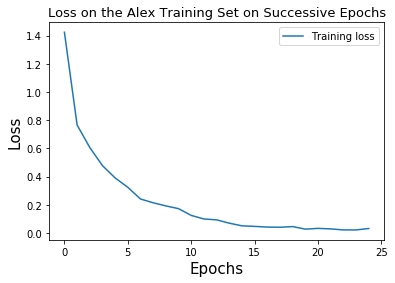

In [0]:
# plotting the training loss
plt.plot(train_losses, label='Training loss')
plt.title('Loss on the Alex Training Set on Successive Epochs',size= 13)
plt.legend()
plt.xlabel('Epochs',size= 15)
plt.ylabel('Loss',size=15)
plt.show()


In [0]:
# ==========================================
#            Evaluating Network
# ==========================================

def test_model(test_data,model_version):
    start_time = time.time()
    # prediction and Accuracy for Test set
    correct = 0
    total = 0
    model_version.eval()            
    for batch_num, data in enumerate(test_data, 0):
        x_test, y_test = data
        x_test = x_test.float()

        if torch.cuda.is_available():
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        y_pred = model_version(x_test.cuda())
        _, predicted = torch.max(y_pred.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    print('\033[1m' + 'Accuracy of the network by tuning the Alex Network on the test images: %d %%' % (100 * correct / total))
    print('\033[1m' + 'Time Taken for Evaluating Model on Test: ' + '--- %s seconds ---' % round((time.time() - start_time),2))

test_model(testloader_large,model_ft)

Accuracy of the network by tuning the Alex Network on the test images: 80 %
Time Taken for Evaluating Model on Test: --- 0.36 seconds ---


**Strategy A: Extracting Features from the Activation functions of the 2nd last Layer of the Alex Net and using SVM Classiffier**

In [0]:
model_feat = models.alexnet(pretrained=True)
## Removing the last layer and using the 2nd last layer activation functions output as feature vector for SVM Classifier
for param in model_feat.parameters():
    param.requires_grad = False

new_classifier = nn.Sequential(*list(model_feat.classifier.children())[:-1])
model_feat.classifier = new_classifier
print(model_feat)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
## Defining Features Extraction Method

def alex_feat(model,data):
      model = model.cuda()
      start_time = time.time()
      feat_size= model.classifier[4].in_features
      alex_features = np.empty((0, feat_size))
      feat_labels=np.zeros((0,1))
      
      for batch_num, batch_data in enumerate(data, 0):
            x_train, y_train = batch_data   
            x_train = x_train.float()
            y_train= np.reshape(y_train,(y_train.shape[0],1))
            y_train= y_train.numpy()

            x_train = x_train.cuda()
            features = model(x_train).cpu().data.numpy()
            features=features[:,:feat_size]
            alex_features= np.append(alex_features, features, axis=0)
            feat_labels=np.vstack((feat_labels,y_train))
      
      print('\033[1m' + 'Time Taken for Extracting Features: ' + '--- %s seconds ---' % round((time.time() - start_time),2))
      return np.asarray(alex_features.astype('float32')), np.asarray(feat_labels.astype('float32'))


In [0]:
x_train,y_train= alex_feat(model_feat,trainloader_large)
print('\033[1m' + 'Shape of the Training Feature Vector: ' + str(x_train.shape))
print('\033[1m' + 'Shape of the Training Label Vector: ' + str(y_train.shape))
print('\n')
x_test,y_test=  alex_feat(model_feat,testloader_large)
print('\033[1m' + 'Shape of the Test Feature Vector: ' + str(x_test.shape))
print('\033[1m' + 'Shape of the Test Label Vector: ' + str(y_test.shape))


Time Taken for Extracting Features: --- 2.55 seconds ---
Shape of the Training Feature Vector: (2400, 4096)
Shape of the Training Label Vector: (2400, 1)


Time Taken for Extracting Features: --- 0.34 seconds ---
Shape of the Test Feature Vector: (400, 4096)
Shape of the Test Label Vector: (400, 1)


**Training the SVM Classifier and Model Accuracy**

In [0]:
# training a linear SVM classifier 
start_time = time.time()
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

svm_model_linear = svm.LinearSVC(random_state=0,tol=1e-5,C=1,max_iter= 5000)
svm_model_linear.fit(x_train, y_train.ravel())

test_predictions = svm_model_linear.predict(x_test) 
accuracy= accuracy_score(y_test, test_predictions)

print ('\033[1m' + 'Accuracy Observed with SVM Classifier  = ' + str(accuracy*100 ) + '%')
print('\033[1m' + 'Time Taken for Classification: ' + '--- %s seconds ---' % round((time.time() - start_time),2))


Accuracy Observed with SVM Classifier  = 78.5%
Time Taken for Classification: --- 2.88 seconds ---


### **Accuracy observed by using 2nd Last Layer Acitvation Functions as our feature vector for the classifier SVM gives a highly improved accuracy of 78.5% compared to the previous Bag of Sift descriptors approach**

**Bonus: Fine Tuning VGG Network**

In [0]:
# ==========================================
#       Fine-Tune Pretrained Alex Network
# ==========================================
num_classes=16

import torchvision.models as models

##Initialising the Model for the Alex Net for fine tuning with the ouput Layer to 16 classess

def initialize_model(num_classes, use_pretrained=True):
    model_ft = None
    input_size = 0
    model_ft = models.vgg16(pretrained=use_pretrained)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes) 
    
    return model_ft

# Initialize the model
model_vgg = initialize_model(num_classes, use_pretrained=True)
print(model_vgg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
#checking if GPU is available
if torch.cuda.is_available():
    model_vgg = model_vgg.cuda()

In [0]:
feature_extract= False
params_to_update = model_vgg.parameters()
print("Params to learn:")

for name,param in model_vgg.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# All parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum= 0.9)
exp_lr_scheduler= optim.lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma= 0.1)

criterion = nn.CrossEntropyLoss()


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.2.weight
	 features.2.bias
	 features.5.weight
	 features.5.bias
	 features.7.weight
	 features.7.bias
	 features.10.weight
	 features.10.bias
	 features.12.weight
	 features.12.bias
	 features.14.weight
	 features.14.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 features.21.weight
	 features.21.bias
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [0]:
##Training the Method1 Model
start_time = time.time()
n_epochs = 20
train_losses=[]

for epoch in range(n_epochs):
    model_vgg.train()
    print('\033[1m' + 'Performance Statistics for Epoch Number :' + str(epoch + 1))
    train_running_loss = 0.0
    train_total_loss= 0.0
    for batch_num, data in enumerate(trainloader_large, 0):
        # getting the inputs; data is a tensor tuple list of [inputs, labels]
        x_train, y_train = data   
        x_train = x_train.float() 

        # converting the data into GPU format
        if torch.cuda.is_available():
            x_train = x_train.cuda()
            y_train = y_train.cuda()

        optimizer_ft.zero_grad()
        output_train = model_vgg(x_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer_ft.step()

        # print statistics
        train_running_loss += loss_train.item()
        train_total_loss += loss_train.item()

        if batch_num % 20 == 19:    # print every 20 mini-batches
            print('\033[1m' + '[Batch NO.: %d, Mini Batch: %5d] loss: %.3f' %
                  (epoch + 1, batch_num + 1, train_running_loss / 20))
            train_running_loss = 0.0
    train_losses.append(train_total_loss/(batch_num + 1))
    
    print('\033[1m' + '[Avg Loss for the Epoch NO.: %d, Loss: %.3f]' % (epoch + 1, train_total_loss/(batch_num + 1)))
    print('\n')

print('Finished Training')
print('\033[1m' + 'Time Taken to Train the Model: ' + '--- %s mins ---' % round((time.time() - start_time)/60,2))


Performance Statistics for Epoch Number :1
[Batch NO.: 1, Mini Batch:    20] loss: 2.572
[Batch NO.: 1, Mini Batch:    40] loss: 1.660
[Avg Loss for the Epoch NO.: 1, Loss: 1.970]


Performance Statistics for Epoch Number :2
[Batch NO.: 2, Mini Batch:    20] loss: 1.115
[Batch NO.: 2, Mini Batch:    40] loss: 0.919
[Avg Loss for the Epoch NO.: 2, Loss: 0.983]


Performance Statistics for Epoch Number :3
[Batch NO.: 3, Mini Batch:    20] loss: 0.818
[Batch NO.: 3, Mini Batch:    40] loss: 0.701
[Avg Loss for the Epoch NO.: 3, Loss: 0.734]


Performance Statistics for Epoch Number :4
[Batch NO.: 4, Mini Batch:    20] loss: 0.660
[Batch NO.: 4, Mini Batch:    40] loss: 0.674
[Avg Loss for the Epoch NO.: 4, Loss: 0.647]


Performance Statistics for Epoch Number :5
[Batch NO.: 5, Mini Batch:    20] loss: 0.475
[Batch NO.: 5, Mini Batch:    40] loss: 0.508
[Avg Loss for the Epoch NO.: 5, Loss: 0.488]


Performance Statistics for Epoch Number :6
[Batch NO.: 6, Mini Batch:    20] loss: 0.417
[

In [0]:
# ==========================================
#            Evaluating Network
# ==========================================

def test_model(test_data,model_version):
    start_time = time.time()
    # prediction and Accuracy for Test set
    correct = 0
    total = 0
    model_version.eval()            
    for batch_num, data in enumerate(test_data, 0):
        x_test, y_test = data
        x_test = x_test.float()

        if torch.cuda.is_available():
            x_test = x_test.cuda()
            y_test = y_test.cuda()

        y_pred = model_version(x_test.cuda())
        _, predicted = torch.max(y_pred.data, 1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()

    print('\033[1m' + 'Accuracy of the network by tuning the VGG Network on the test images: %d %%' % ( 100 * correct / total))
    print('\033[1m' + 'Time Taken for Evaluating Model on Test: ' + '--- %s seconds ---' % round((time.time() - start_time),2))

test_model(testloader_large,model_vgg)

Accuracy of the network by tuning the VGG Network on the test images: 84 %
Time Taken for Evaluating Model on Test: --- 4.87 seconds ---


### **Tuning the Network with Alex Net increases our accuracy by 4-5%**

### ***Complete Report for the Question 2:***

**Part1 : Implementing Startegy B --> Fine tuning Alex Net**

>  Changing the Number of output features in the final layer of the classifier to 16: Linear(in_features=4096, out_features=16, bias=True)
*   Time taken for training the New Alex Net with our Training data set= 2.2mins and time taken for evaluating the model on test data 0.36secs
*   **Accuracy Observed = 80%**

**Part2 : Implementing Startegy A --> Using Activation Functions of 2nd Last Layer as feature vector and training SVM Classifier**

>  Extracting Features from the Activation functions of the 2nd last Layer of the Alex Net and using SVM Classiffier
*  Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True)
*   Time taken for extracting the training features form the Alex penultimate layer= 2.55secs and time taken for extracting the test features = 0.34secs
*  Time taken for SVM classification = 2.88secs
*   **Accuracy Observed = 78.5%, highly improved accuracy comapred with Bag of SIFT descriptors approach in previous assignemnt**

**Part3 : Bonus --> Fine tuning VGG Net**

>  Fine tuning the last yaer of the VGG16 net, Changing the Number of output features in the final layer of the classifier to 16
* Linear(in_features=4096, out_features=16, bias=True)
*   Time taken for training the New VGG Net with our Training data set= 24.6mins and time taken for evaluating the model on test data 4.87secs
*   **Accuracy Observed = 84%, improves our accuracy slighlty with VGG Net**


## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
